In [1]:
### INITIALIZATION

import pandas as pd # Data structures
import numpy as np # Matrix algebra
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters # Plotting
register_matplotlib_converters() # Plotting
import seaborn as sns # Plotting
import gc # Garbage collection

In [2]:
### VERSIONS CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [3]:
### MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Regions:
list_region = ['DM', 'EM', 'FM']
### UN Comtrade adopted data containers:
str_path_unc_res_all_annual = 'Data_Files/Source_Files/unc_res_all_annual.h5'
str_path_unc_res_all_zz = 'Data_Files/Source_Files/unc_res_all_world.h5'
### File with aggregated flows:
str_path_unc_res_flows = 'Data_Files/Source_Files/unc_res_flows.h5'
### Universal HDF5 key:
str_key_unc_res = 'unc_res'
### File with Import incorporation options:
str_path_unc_export = 'Data_Files/Source_Files/unc_comtrade_export.h5'
### Export key:
str_key_unc_export = 'export_augmented'
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Connection tables path and sheets:
str_path_to_gics = 'Data_Files/Source_Files/goods_to_industries_HS.xlsx'
str_serv_sheet = 'EBOPS'
str_comm_sheet = 'AG2'
### Dates:
str_date_end = '2021-12-31'

In [4]:
### DEFINING EXTRACTION ISON UNIVERSE DATA FROM MS EXCEL SOURCE

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                    na_values = list_na_excel_values, keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [5]:
### ISON DATA EXTRACTION STEPS

### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON countrys status on 2021-12-31:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
ser_ison_status.index.name = 'Reporter'

In [ ]:
### EXPORT AND REVERTED IMPORT CONCATENATION

### Results container:
list_export_aug = []
### Countries portion length:
int_portion = 5
### Looping over countrie portions:
for iter_num in range(len(ser_ison_status.index) // int_portion + 1):
    gc.collect()    
    ### Portion of countries selecting:
    list_countries = list(ser_ison_status.index)[int_portion * iter_num : int_portion * (iter_num + 1)]
    if (len(list_countries) > 0):
        print(list_countries)
        ### Export data loading:
        ser_unc_export = pd.read_hdf(str_path_unc_res_all_annual, key = str_key_unc_res,
                                     where = "(Flow = 'Export') & (Reporter in list_countries) & (Partner != 'World')").droplevel('Flow')
        print('Export dataset loaded')
        ### Import data loading:
        ser_unc_import = pd.read_hdf(str_path_unc_res_all_annual, key = str_key_unc_res, 
                                     where = "(Flow = 'Import') & (Partner in list_countries)").droplevel('Flow')
        print('Import dataset loaded')    
        ### Import data reverting:
        ser_unc_import.index.set_names('Partner_Inv', level = 1, inplace = True)
        ser_unc_import.index.set_names('Reporter', level = 2, inplace = True)
        ser_unc_import.index.set_names('Partner', level = 1, inplace = True)
        ser_unc_import = ser_unc_import.swaplevel('Reporter', 'Partner').sort_index()
        print('Import dataset reverted')
        ### Datasets concatenation:
        df_export_aug = pd.concat([ser_unc_export, ser_unc_import], axis = 1, names = 'Source Flow', keys = ['Export', 'Import'])
        del ser_unc_export
        del ser_unc_import    
        gc.collect()    
        print('Export and reverted Import dataset concatenated')    
        df_export_aug = df_export_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).sort_index()
        print('Concatenated dataset index sorted')
        list_export_aug.append(df_export_aug)
        del df_export_aug
        gc.collect()
        print('Aggregated dataset added to container')
    #    break
### Container elements concatenation:
df_export_aug_full = pd.concat(list_export_aug, axis = 0, sort = False)
del list_export_aug
gc.collect()    
### Index levels casting:
df_export_aug_full = df_export_aug_full.reset_index()\
                                       .astype({'Reporter': 'category', 'Partner': 'category', 'Type': 'category', 'Commodity_ID': 'category', 'Market': 'category'})\
                                       .set_index(['Date', 'Reporter', 'Partner', 'Type', 'Commodity_ID', 'Market'])
### Results saving:
df_export_aug_full.to_hdf(str_path_unc_res_flows, key = str_key_unc_res, mode = 'w', format = 'table', complevel = 9)

In [6]:
### GOODS & SERVICES TO INDUSTRIES CONNECTION

dict_to_gics_raw = pd.read_excel(engine = 'openpyxl', io = str_path_to_gics, sheet_name = [str_serv_sheet, str_comm_sheet], 
                                 header = 0, parse_dates = False, dtype = str, usecols = list(range(9)),
                                 na_values = list_na_excel_values, keep_default_na = False)
df_serv_to_gics = dict_to_gics_raw[str_serv_sheet].drop(['USA to World Export Full History, %', 'Parent ID'], axis = 1).dropna(subset = ['GICS Industry Group'])
df_serv_to_gics.set_index('Service ID', inplace = True)
df_serv_to_gics.index.names = ['Category_ID']
df_serv_to_gics.rename({'Service Description': 'Category_Description'}, axis = 1, inplace = True)
df_comm_to_gics = dict_to_gics_raw[str_comm_sheet].drop('2021 USA to World Export', axis = 1).dropna(subset = ['GICS Industry Group'])
df_comm_to_gics.set_index('Commodity ID', inplace = True)
df_comm_to_gics.index.names = ['Category_ID']
df_comm_to_gics.rename({'AG2': 'Category_Description'}, axis = 1, inplace = True)
### Preparation to mapping:
ser_hs_to_gics = pd.concat([df_comm_to_gics, df_serv_to_gics], axis = 0, sort = False)['GICS Group Code']
dict_hs_to_gics = dict(zip(ser_hs_to_gics.index, ser_hs_to_gics.values))

In [8]:
### AGGREGATED DATASET LOADING:

df_export_aug_full = pd.read_hdf(str_path_unc_res_flows, key = str_key_unc_res)
### Filtering services of the needed level:
df_export_aug_full = pd.concat([df_export_aug_full.loc[(All, All, All, 'Goods', All, All), All],
                                df_export_aug_full.loc[(All, All, All, 'Services', df_serv_to_gics.index.to_list(), All), All]], axis = 0)

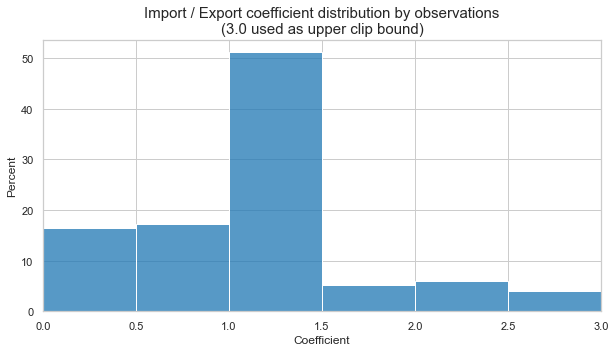

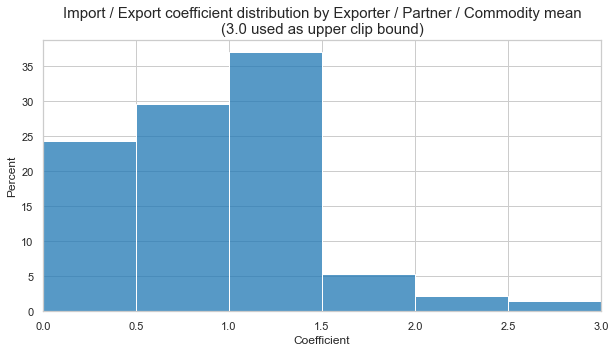

In [9]:
### IMPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS ANALYSIS

gc.collect()
### Observations with the largest absolute difference berween sources:
df_inter_aug = (df_export_aug_full.dropna() / 1000000000).round(2)
df_inter_aug['Difference'] = (df_inter_aug['Export'] - df_inter_aug['Import']).abs()
df_inter_aug.loc[df_inter_aug['Difference'].nlargest(20).index]
### Import / Export Coefficient distribution by observation:
flo_upper_bound = 3.0
df_inter_aug['Coefficient'] = (df_inter_aug['Import'] / df_inter_aug['Export']).round(2).clip(upper = flo_upper_bound)
df_to_plot = df_inter_aug.dropna().loc[df_inter_aug['Export'] > 0.001, 'Coefficient'].reset_index()
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize = (10, 5))
ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
ax_coeff_dist.set_title('Import / Export coefficient distribution by observations\n' + '(' + str(flo_upper_bound) + ' used as upper clip bound)', fontsize = 15)
ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
plt.show()
### Import / Export Coefficient distribution by Exporter / Partner / Commodity averages:
flo_upper_bound = 3.0
df_to_plot = df_inter_aug.dropna().loc[df_inter_aug['Export'] > 0.001].groupby(['Reporter', 'Partner', 'Commodity_ID'])['Coefficient'].mean().reset_index()
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize = (10, 5))
ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
ax_coeff_dist.set_title('Import / Export coefficient distribution by Exporter / Partner / Commodity mean\n' + '(' \
                        + str(flo_upper_bound) + ' used as upper clip bound)', fontsize = 15)
ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
plt.show()

In [ ]:
### CIF COEFFICIENTS CALCULATION

gc.collect()

### Bounds to filter bilateral Import to Export ratio before median calculation:
flo_lower_bound = 1.0
flo_upper_bound = 2.0

### Bilateral median calculation procedure:
def get_obs_median(df_comm):
    ### Export to Import ratio:
    ser_obs_coeff = df_comm['Import'] / df_comm['Export']
    ### Ratio filtering:
    ser_obs_coeff = ser_obs_coeff.loc[(ser_obs_coeff >= flo_lower_bound) & (ser_obs_coeff <= flo_upper_bound)]
    ### Filtered timeseries median as a result:
    return ser_obs_coeff.median()

### CIF calculation procedure for bilateral series by commodity:
def get_cif_coefficient(df_group):
    ### Bilateral median calulation:
    df_comm = df_group.droplevel(['Commodity_ID', 'Market'])
    ser_bilateral_median = df_comm.groupby(['Reporter', 'Partner']).apply(get_obs_median)
    ### General commodity median calculation:
    flo_median = ser_bilateral_median.median()
    print(df_group.iloc[0 : 1].index.to_list()[0][3 : 5], ':', flo_median)
    ### Filling missed bilateral values with general commodity median:
    if not (np.isnan(flo_median)):
        ser_bilateral_median.fillna(flo_median, inplace = True)
    ### Results output:
    return ser_bilateral_median

### Calulation CIF coefficient for all commodities:
ser_cif_median = df_export_aug_full.groupby(['Commodity_ID']).apply(get_cif_coefficient)
ser_cif_median = ser_cif_median.reorder_levels(['Reporter', 'Partner', 'Commodity_ID'])
ser_cif_median.name = 'CIF_Coefficient'
#df_test = df_export_aug.loc[(All, All, All, All, ['Crude', 'Coffee'], All), All]
#ser_test = df_test.groupby(['Commodity_ID', 'Commodity_Name']).apply(get_cif_coefficient)

In [18]:
### DATA INCORPORATION:

gc.collect()
### Adding CIF coefficients to dataset:
df_export_cif = df_export_aug_full.merge(ser_cif_median, left_index = True, right_index = True)
df_export_cif = df_export_cif.reorder_levels(['Date', 'Reporter', 'Partner', 'Type', 'Commodity_ID', 'Market'])
### Import correction:
df_export_cif['Import_Corrected'] = df_export_cif['Import'] / df_export_cif['CIF_Coefficient']
### Combining Export & Import data:
df_export_cif['Export_Augmented'] = df_export_cif['Export'].combine_first(df_export_cif['Import_Corrected'])
df_export_cif.drop('CIF_Coefficient', axis = 1, inplace = True)

In [ ]:
### TEMP

#df_export_cif#.loc[(All, 'IL', 'US', All, '01', All), All]
#ser_cif_median.loc['IL', 'US', '01']

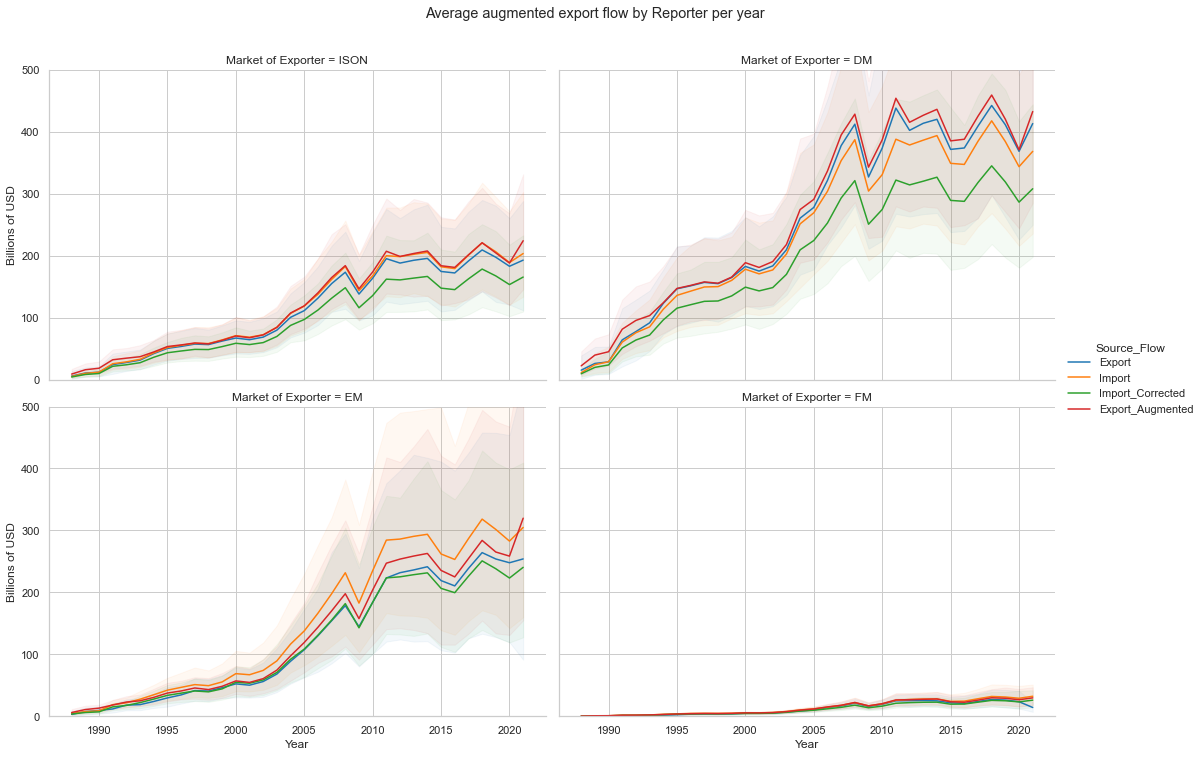

In [26]:
### IMPORT OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()
### Incorporation options:
df_options_sum = df_export_cif.groupby(['Date', 'Reporter', 'Market']).sum() / 1000000000
ser_options_sum = df_options_sum.reset_index().melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Source_Flow', value_name = 'Export_Volume')\
                                .set_index(['Date', 'Reporter', 'Market', 'Source_Flow']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['ISON'] = ser_options_sum.droplevel('Market')
for iter_region in list_region:
    dict_options_sum[iter_region] = ser_options_sum.loc[All, All, iter_region, All]
### Export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Exporter']).reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Year', y = 'Export_Volume', col = 'Market of Exporter', col_wrap = 2, hue = 'Source_Flow', 
                              kind = 'line', aspect = 1.5, err_kws = {'alpha': 0.05})
fig_mean_unique.fig.suptitle('Average augmented export flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 500))
plt.show()

In [41]:
### MEMORY OPTIMIZATION:

ser_export_cif = df_export_cif['Export_Augmented'].astype('float32').droplevel('Market')
del df_export_cif
gc.collect()
ser_export_cif = ser_export_cif.reset_index(['Reporter', 'Partner', 'Commodity_ID'])\
                               .astype({'Reporter': 'category', 'Partner': 'category','Commodity_ID': 'category'})\
                               .set_index(['Reporter', 'Partner', 'Commodity_ID'], append = True)\
                               .reorder_levels(['Date', 'Reporter', 'Partner', 'Type', 'Commodity_ID'])

419

In [50]:
### IMPORT OBSERVATIONS INCORPORATION: INCORPORATION OPTIONS SAVING

gc.collect()
### Incorporation options:
ser_export_cif.to_hdf(str_path_unc_export, key = str_key_unc_export, mode = 'w', format = 'table', complevel = 9)

In [5]:
### IMPORT OBSERVATIONS INCORPORATION: INCORPORATION OPTIONS LOADING

ser_export_cif = pd.read_hdf(str_path_unc_export, key = str_key_unc_export)

In [6]:
### GOODS & SERVICES TO INDUSTRIES CONNECTION

dict_to_gics_raw = pd.read_excel(engine = 'openpyxl', io = str_path_to_gics, sheet_name = [str_serv_sheet, str_comm_sheet], 
                                 header = 0, parse_dates = False, dtype = str, usecols = list(range(9)),
                                 na_values = list_na_excel_values, keep_default_na = False)
df_serv_to_gics = dict_to_gics_raw[str_serv_sheet].drop(['USA to World Export Full History, %', 'Parent ID'], axis = 1).dropna(subset = ['GICS Industry Group'])
df_serv_to_gics.set_index('Service ID', inplace = True)
df_serv_to_gics.index.names = ['Category_ID']
df_serv_to_gics.rename({'Service Description': 'Category_Description'}, axis = 1, inplace = True)
df_comm_to_gics = dict_to_gics_raw[str_comm_sheet].drop('2021 USA to World Export', axis = 1).dropna(subset = ['GICS Industry Group'])
df_comm_to_gics.set_index('Commodity ID', inplace = True)
df_comm_to_gics.index.names = ['Category_ID']
df_comm_to_gics.rename({'AG2': 'Category_Description'}, axis = 1, inplace = True)
### Preparation to mapping:
ser_hs_to_gics = pd.concat([df_comm_to_gics, df_serv_to_gics], axis = 0, sort = False)['GICS Group Code']
dict_hs_to_gics = dict(zip(ser_hs_to_gics.index, ser_hs_to_gics.values))

In [7]:
### CONVERTING TRADE ELEMENTS TO INDUSTRIES & SAVING

df_export_gics = ser_export_cif.reset_index('Commodity_ID')
del ser_export_cif
gc.collect()
df_export_gics['GICS_ID'] = df_export_gics['Commodity_ID'].replace(dict_hs_to_gics)
ser_export_gics = df_export_gics.astype({'GICS_ID': 'category'}).set_index(['Commodity_ID', 'GICS_ID'], append = True)['Export_Augmented']
ser_export_gics.to_hdf('Data_Files/Source_Files/comtrade_export_bilateral.h5', key = 'export_augmented', mode = 'w', format = 'table', complevel = 9)

In [8]:
### WORLD EXPORT DATA ADDING

gc.collect()
### Total trading:
ser_comm_world = pd.read_hdf(path_or_buf = str_path_unc_res_all_annual, key = str_key_unc_res, where = "(Partner = 'World') & ('Flow' = 'Export')")\
                   .droplevel(['Flow', 'Partner'])
### Adding empty cells to fill:
ser_comms = ser_comm_world.droplevel(['Date', 'Reporter']).reset_index('Type').drop('Value', axis = 1).squeeze()
ser_comm_world = ser_comm_world.unstack(['Date', 'Reporter']).stack(['Date', 'Reporter'], dropna = False)\
                               .reorder_levels(['Date', 'Reporter', 'Type', 'Commodity_ID'])
### Calculation of the sum of augmented Export for ISON universe:
ser_ison_sum = ser_export_gics.groupby(['Date', 'Reporter', 'Type', 'Commodity_ID']).sum()
### Datasets combining:
ser_comm_world_aug = ser_comm_world.combine_first(ser_ison_sum)
ser_comm_world_aug.name = 'Export_Augmented'
### Dataset saving:
df_export_world = ser_comm_world_aug.reset_index('Commodity_ID')
df_export_world['GICS_ID'] = df_export_world['Commodity_ID'].replace(dict_hs_to_gics)
ser_export_world = df_export_world.astype({'GICS_ID': 'category'}).set_index(['Commodity_ID', 'GICS_ID'], append = True)['Export_Augmented'].dropna()
ser_export_world.to_hdf('Data_Files/Source_Files/comtrade_export_world.h5', key = 'export_augmented', mode = 'w', format = 'table', complevel = 9)

In [4]:
### TEMP

pd.read_hdf('Data_Files/Source_Files/comtrade_export_bilateral.h5', key = 'export_augmented')

Date        Reporter  Partner  Type   Commodity_ID  GICS_ID
1999-12-31  AE        AR       Goods  01            3020       1.853108e+04
2007-12-31  AE        AR       Goods  01            3020       1.090000e+02
2009-12-31  AE        AR       Goods  01            3020       3.000000e+02
2010-12-31  AE        AR       Goods  01            3020       1.273000e+03
2011-12-30  AE        AR       Goods  01            3020       3.370000e+02
                                                                   ...     
2017-12-29  ZM        ZA       Goods  99            99         1.725071e+06
2018-12-31  ZM        ZA       Goods  99            99         1.144333e+06
2019-12-31  ZM        ZA       Goods  99            99         7.239370e+05
2020-12-31  ZM        ZA       Goods  99            99         6.401480e+05
2019-12-31  ZM        ZM       Goods  90            4520       2.146287e+01
Name: Export_Augmented, Length: 11588208, dtype: float32

In [16]:
#### INDUSTRY VALUES SUM
#
#### Industry container:
#dict_industry = {}
#### Industries list:
#list_industries = sorted(list(set(ser_hs_to_gics.values)))[: -1]
#### Looping over industries:
#for iter_number, iter_gics_code in enumerate(list_industries):
#    print(str(iter_number + 1) + ' / ' + str(len(list_industries)) + ' : ' + iter_gics_code)
#    dict_industry[iter_gics_code] = ser_export_gics.loc[All, All, All, All, iter_gics_code].groupby(['Date', 'Reporter', 'Partner']).sum().dropna()
##    break
#### Results aggregation:
#ser_export_industry = pd.concat(dict_industry, names = ['GICS_ID'])
#ser_export_industry = ser_export_industry.reset_index('GICS_ID').astype({'GICS_ID': 'category'}).set_index('GICS_ID', append = True)
#### Results saving:
#ser_export_industry.to_hdf(str_path_gics_export, key = str_key_gics_export, mode = 'w', format = 'table', complevel = 9)

1 / 16 : 1010
2 / 16 : 1510
3 / 16 : 2010
4 / 16 : 2020
5 / 16 : 2030
6 / 16 : 2520
7 / 16 : 2530
8 / 16 : 3020
9 / 16 : 3030
10 / 16 : 3520
11 / 16 : 4020
12 / 16 : 4030
13 / 16 : 4510
14 / 16 : 4520
15 / 16 : 5010
16 / 16 : 5020


In [28]:
### TEMP

